In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/My Drive/data/viettri_quality.csv', index_col='date')

In [4]:
data.fillna(method='ffill', inplace=True)
scaler = MinMaxScaler()
data['pm25'] = scaler.fit_transform(data[['pm25']])

In [21]:
def create_sequences(data, seq_length=30):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(data['pm25'].values, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(seq_length, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 30)                0         
                                                                 
 dense_9 (Dense)             (None, 128)               3968      
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12289 (48.00 KB)
Trainable params: 12289 (48.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/100
54/54 [==============================] - 2s 8ms/step - loss: 0.0267 - val_loss: 0.0137
Epoch 2/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0208 - val_loss: 0.0141
Epoch 3/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0198 - val_loss: 0.0133
Epoch 4/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0189 - val_loss: 0.0153
Epoch 5/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0180 - val_loss: 0.0133
Epoch 6/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0176 - val_loss: 0.0132
Epoch 7/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0159 - val_loss: 0.0132
Epoch 8/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0153 - val_loss: 0.0170
Epoch 9/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0144 - val_loss: 0.0132
Epoch 10/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 11/

In [25]:
# Predict the next 30 days PM2.5 values
last_sequence = X_test[-1]
predictions = []
current_sequence = last_sequence

for _ in range(30):
    next_value = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
    predictions.append(next_value)
    current_sequence = np.append(current_sequence[1:], [[next_value]], axis=0)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print("Next 30 days PM2.5 predictions:", predictions.flatten())

1/1 [==============================] - 0s 21ms/step
Next 30 days PM2.5 predictions: [17.767124 29.82477  32.53962  35.431435 33.41329  29.108152 32.611675
 28.249865 25.985228 32.195168 31.297092 37.79561  40.696743 32.21136
 23.768171 20.45569  29.217556 40.577938 45.345898 33.94833  19.119284
 26.21479  34.475063 35.81022  40.062115 28.111721 29.435652 35.091843
 28.553291 27.974724]


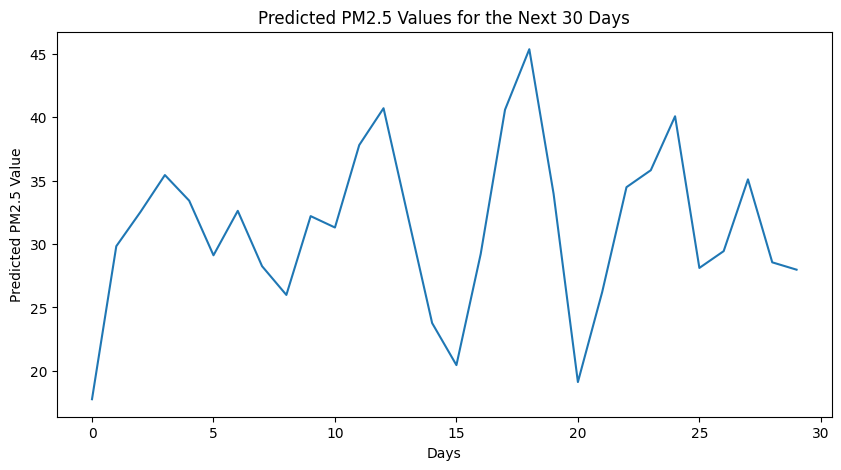

In [26]:
# Plot the predictions in the original scale
plt.figure(figsize=(10, 5))
plt.plot(predictions)
plt.title('Predicted PM2.5 Values for the Next 30 Days')
plt.xlabel('Days')
plt.ylabel('Predicted PM2.5 Value')
plt.show()